# Detectando objetos com YOLO v4 e OpenCV

## Visão geral

No notebook anterior, utilizamos o framework Darknet para realizar a detecção de objetos em imagens com o You only look once (YOLO). Entretanto, também é possível empregar o módulo cv2, que corresponde à implementação do OpenCV em Python, para executar a mesma tarefa, sem a necessidade de compilar (buildar) o framework Darknet.

## Etapa 1 - Importando as bibliotecas

In [1]:
import cv2

print(cv2.__version__)

4.12.0


## Etapa 2 - Conectando com o Google Drive

In [2]:
# Desnecessario

## Etapa 3 - Carregando os arquivos do modelo treinado

In [3]:
import utils

# Obter pesos, configuracao da arquitetura e labels da rede neural do modelo
yolov3 = utils.carregar_yolov3()
yolov3

yolov3(labels_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/coco.names', weights_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/yolov3.weights', config_path='/home/rapha/Cursos/opencv-yolo-darknet/shared/modelo_YOLOv3/yolov3.cfg', labels=['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell 

In [4]:
# Carregar a rede YOLOv3 no módulo DNN (Deep Neural Network) do OpenCV
net = cv2.dnn.readNet(yolov3.config_path, yolov3.weights_path)
net

< cv2.dnn.Net 0x7f520cc5de50>

## Etapa 4 - Definindo mais configurações para a detecção

In [5]:
import numpy as np

# Gerar cores RGB aleatorias para "colorir" o contorno da caixa delimitadora de cada label/classe detectada
# NOTE: o OpenCV trabalha com o sistema de cores BGR ao inves do RGB
colors = np.random.randint(0, 255, size=(len(yolov3.labels), 3), dtype='uint8')
colors[:5]

array([[163, 141, 225],
       [239, 227,  58],
       [ 78,  42, 155],
       [ 88, 248,  80],
       [157, 235,   3]], dtype=uint8)

Como é possível ver a seguir, uma rede neural pode ter mais de uma camada de saída, ou seja, camadas que recebem conexões da camada anterior, mas não se conectam a nenhuma camada seguinte.

**ATENÇÃO:** o número de camadas de saída em uma CNN não deve ser confundido com o número de labels (classes) que o modelo é capaz de prever.

In [6]:
# Lista com os identificadores (IDs) de todas as camadas da rede
ln = net.getLayerNames()

# Retorna os índices (baseados em 1) das camadas de saida
ln_saida_indices = net.getUnconnectedOutLayers()

# IDs das camadas de saída
ln_saida_ids = tuple(ln[i - 1] for i in ln_saida_indices)

print('Todas as camadas:', ln)
print('Camadas de saída:', ln_saida_ids)
print('Total de camadas: ' + str(len(ln)))

Todas as camadas: ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37'

## Etapa 5 - Carregando a imagem onde será feita a detecção

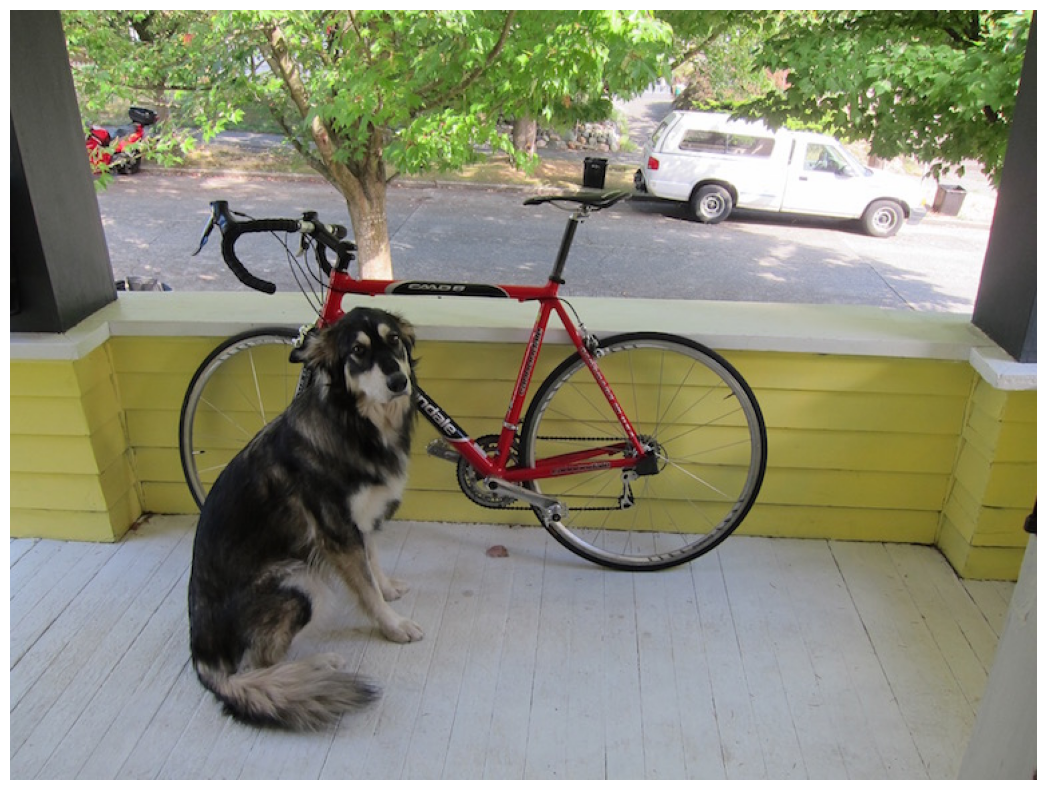

In [7]:
imagem = utils.mostrar_imagem('dog.jpg')

In [8]:
imagem_cp = imagem.copy()
(H, W) = imagem_cp.shape[:2]
print(f'Dimensoes da imagem: {H} x {W} px')

Dimensoes da imagem: 576 x 768 px


## Etapa 6 - Processando a imagem de entrada

Antes que a Rede Neural Convolucional (CNN) possa realizar inferências, a imagem precisa passar por um pré-processamento.
O objetivo aqui não é detectar objetos ainda, mas preparar os dados de forma que a rede consiga trabalhar corretamente.

Um dos métodos usados para isso é o blobFromImage, que aplica duas transformações principais:

1. **Subtração da média (mean subtraction):** remove valores médios de cor da imagem, reduzindo problemas relacionados à variação de iluminação. Isso garante que a CNN foque mais nos padrões visuais (formas, bordas, texturas) e menos nas diferenças de brilho.

2. **Redimensionamento (resizing):** ajusta a largura e altura da imagem para o tamanho de entrada exigido pela CNN.

Dessa forma, todas as imagens entram na rede com o mesmo formato, independentemente da resolução original.

In [9]:
import time

fator_escala = 1 / 255.0            # Fator em que a imagem sera redimensionada
tamanho_esperado_rn = (416, 416)    # Tamanho da imagem esperado pela CNN
trocar_rgb = True                   # Inverter canais RGB (o OpenCV trabalha com BGR)?
cortar_imagem = False               # Cortar imagem para se adequar ao tamanho esperado?

inicio = time.time()

# Converter imagem para formato de blob
blob = cv2.dnn.blobFromImage(
    image=imagem,
    scalefactor=fator_escala,
    size=tamanho_esperado_rn,
    swapRB=trocar_rgb,
    crop=cortar_imagem,
)

# Enviar imagem para a rede neural
net.setInput(blob=blob)

# Processar a imagem na CNN e obter as respostas das camadas de saída
# O método forward percorre a rede: processa a imagem desde as camadas de entrada até as camadas de saída
layer_outputs = net.forward(ln_saida_ids)

termino = time.time()

print("YOLO levou {:.2f} segundos".format(termino - inicio))

YOLO levou 1.14 segundos


## Etapa 7 - Definindo as variáveis para a detecção

In [10]:
threshold = 0.5
threshold_NMS = 0.3 # Non-Max supression: caixas com probabilidade de ter um objeto abaixo desse percentual sao descartadas
caixas = []
confiancas = []
IDclasses = []

## Etapa 8 - Realizando a predição

A detecção retornada por uma camada de saída da rede YOLO é codificada em uma matriz cujas linhas correspondem as caixas delimitadoras e as colunas a coeficientes de probabilidade, como mostrado na imagem a seguir

![Image size function](./img/cnn-yolo.webp)

In [11]:
# Para cada camada de saída da rede neural (a rede pode ter várias saídas)
for output in layer_outputs:
    # Para cada detecção feita nessa camada
    for detection in output:
        # Os primeiros 5 valores de detection são: [pc, bx, by, bw, bh]
        # A partir da posição 5 temos as probabilidades de cada classe
        scores = detection[5:]
        
        # Recupera o índice da classe com maior probabilidade
        classeID = np.argmax(scores)
        
        # Recupera o valor da confiança (probabilidade de realmente ser esse objeto)
        confianca = scores[classeID]

        # Só continua se a confiança for maior que o limiar definido
        if confianca > threshold:
            # print("scores: " + str(scores))
            # print("classe mais provavel: " + str(classeID))

            # Construção da caixa delimitadora ao redor do objeto detectado
            # detection[0:4] = [centerX, centerY, width, height], normalizados entre 0 e 1
            # Multiplicamos por [W, H, W, H] para escalar para o tamanho real da imagem
            caixa = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = caixa.astype("int")

            # Conversão de coordenadas: de centro (centerX, centerY) para canto superior esquerdo (x, y)
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # Adiciona a caixa calculada à lista de caixas
            caixas.append([x, y, int(width), int(height)])

            # Adiciona a confiança dessa detecção à lista de confiabilidades
            confiancas.append(float(confianca))

            # Adiciona o ID da classe detectada à lista de classes
            IDclasses.append(classeID)


In [12]:
print(confiancas), len(confiancas)

[0.9369494915008545, 0.8559304475784302, 0.8421569466590881, 0.9129544496536255, 0.8770490884780884, 0.9230250716209412, 0.990092396736145, 0.9846718907356262, 0.985610842704773, 0.5817273855209351, 0.9041657447814941, 0.9979028701782227, 0.9602787494659424, 0.9668749570846558]


(None, 14)

In [13]:
print(IDclasses), len(IDclasses)

[np.int64(7), np.int64(7), np.int64(7), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(16), np.int64(16), np.int64(16), np.int64(16)]


(None, 14)

## Etapa 9 - Aplicando a Non-maxima Suppresion (NMS)

In [14]:
objetos = cv2.dnn.NMSBoxes(caixas, confiancas, threshold, threshold_NMS)
objetos

array([11,  6,  0], dtype=int32)

In [15]:
# Visualizar probabilidade dos objetos detectados
{int(obj): confiancas[obj]*100 for obj in objetos}

{11: 99.79028701782227, 6: 99.0092396736145, 0: 93.69494915008545}

## Etapa 10 - Mostrando o resultado da deteção na imagem

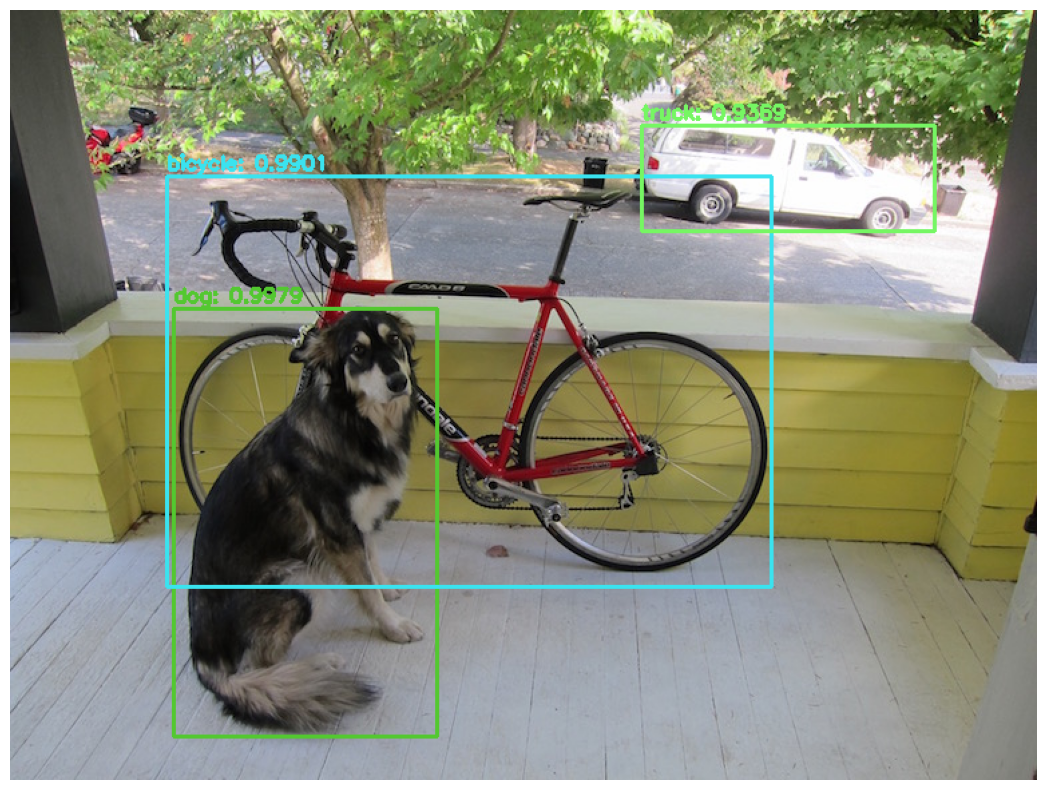

In [16]:
if len(objetos) > 0:
    for i in objetos.flatten():
        (x, y) = (caixas[i][0], caixas[i][1])
        (w, h) = (caixas[i][2], caixas[i][3])

        objeto = imagem_cp[y: y+h, x:x+w]
        # cv2_imshow(objeto)

        cor = [int(c) for c in colors[IDclasses[i]]]

        cv2.rectangle(imagem, (x,y), (x+w, y+h), cor, 2)
        texto = "{}: {:.4f}".format(yolov3.labels[IDclasses[i]], confiancas[i])
        cv2.putText(imagem, texto, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 2)

cv2.imwrite('resultado.jpg', imagem)

utils.mostrar_imagem_cv2(imagem)